# Demo: photosynthesis calculations with and without explicit leaf energy balance

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from datetime import datetime, timedelta
import pandas as pd
%matplotlib widget

In [2]:
sns.set_context('notebook')

## Set pyAPES to path from env file

In [3]:
# setting path
import sys
import os
from dotenv import load_dotenv

load_dotenv()
pyAPES_main_folder = os.getenv('pyAPES_main_folder')

sys.path.append(pyAPES_main_folder)

# force iPython re-import modules at each call
%load_ext autoreload
%autoreload 2

## Import pyAPES modules

In [4]:
from pyAPES.leaf.photo import photo_c3_medlyn_farquhar
from pyAPES.leaf.boundarylayer import leaf_boundary_layer_conductance

## Load input data

In [5]:
input = xr.open_dataset('../data/Demos/data_demo_A_gs.nc')

## Define planttype for which photosynthesis will be calculated

In [6]:
plant = {
     'name': 'Plant1',
        'photop': {
            'Vcmax': 60.0,
            'Jmax': 118.0, 
            'Rd': 1,
            'tresp': { # temperature response parameters (Kattge and Knorr, 2007)
                'Vcmax': [72., 200., 649.],
                'Jmax': [50., 200., 646.],
                'Rd': [33.0],
                'gm': [50., 200., 646.],
                },
            'alpha': 0.25,   # quantum efficiency parameter -
            'theta': 0.7,   # curvature parameter
            'g1': 2.5,      # stomatal slope kPa^(0.5)
            'g0': 4.0e-3,   # residual conductance mol m-2 s-1
            'kn': 0.5,      # nitrogen attenuation coefficient -
            'beta': 0.95,   # co-limitation parameter -
            'drp': [0.39, 0.83, 0.31, 3.0] # Rew-based drought response
            },
        'leafp': {
            'lt': 0.02,     # leaf length scale m
            },
}

# Example 1: Solve A and g<sub>s</sub> assuming thermal equilibrium

We run the photosynthesis function assuming that the leaves are in thermal equilibrium with air. We go through each row in input data and plot a contour surface of net photosynthesis rate as a function of PAR and VPD

leaf_boundary_layer_conductance(u, d, Ta, dT, P=101300.):
- u = mean (horizontal) velocity (m/s)
- d = characteristic length of leaf (m)
- Ta = ambient temperature (degC)
- dT = leaf-air temperature difference (degC)
- P = Pressure (Pa)
- Returns boundary layer conductance for heat, CO<sub>2</sub> and water in this order

photo_c3_medlyn_farquhar(photop, Qp, T, VPD, ca, gb_c, gb_v, P=101300.0)

- photop = See above plant['photop']
- Qp = incident PAR at leaves (umolm-2s-1)
- Tleaf = leaf temperature (degC)
- VPD = leaf-air vapor pressure difference (mol/mol)
- ca = ambient CO2 (ppm)
- gb_c = boundary-layer conductance for co2 (mol m-2 s-1)
- gb_v = boundary-layer conductance for h2o (mol m-2 s-1)
- P - atm. pressure (Pa)
- returns
    - An - net CO2 flux (umolm-2s-1)
    - Rd - dark respiration (umolm-2s-1)
    - fe - leaf transpiration rate (molm-2s-1)
    - gs - stomatal conductance for CO2 (mol/m-2s-1)
    - ci - leaf internal CO2 (ppm)
    - cs - leaf surface CO2 (ppm)

In [7]:
input = input.sel(stand=0)

In [8]:
_, gb_c, gb_v = leaf_boundary_layer_conductance(input.canopy_wind_speed.data, plant['leafp']['lt'], input.canopy_temperature.data, 0.0, input.canopy_pressure.data)

In [9]:
An, Rd, fe, gs, ci, cs = photo_c3_medlyn_farquhar(plant['photop'], input.canopy_leaf_incident_par.data, input.canopy_temperature.data, input.canopy_VPD.data, input.canopy_co2.data, gb_c, gb_v, input.canopy_pressure.data)

In [10]:
data = pd.DataFrame(data=(np.vstack((An, gs, input.canopy_leaf_incident_par.data, input.canopy_VPD.data*input.canopy_pressure.data*1e-3, input.canopy_temperature.data)).T), columns=['An','gs','PAR','VPD','T'])

In [11]:
thresholds = np.percentile(data['VPD'], [1, 25, 50, 75, 99])
data = data.assign(VPD_bins = np.digitize(data['VPD'], thresholds))

def name_vpd_bin(x):
    if x==0:
        return '0-1%'
    elif x==1:
        return '1-25%'
    elif x==2:
        return '25-50%'
    elif x==3:
        return '50-75%'
    elif x==4:
        return '75-99%'
    elif x==5:
        return '99-100%'
    
data = data.assign(VPD_bin_category_name = data['VPD_bins'].map(name_vpd_bin))

(0.0, 0.1)

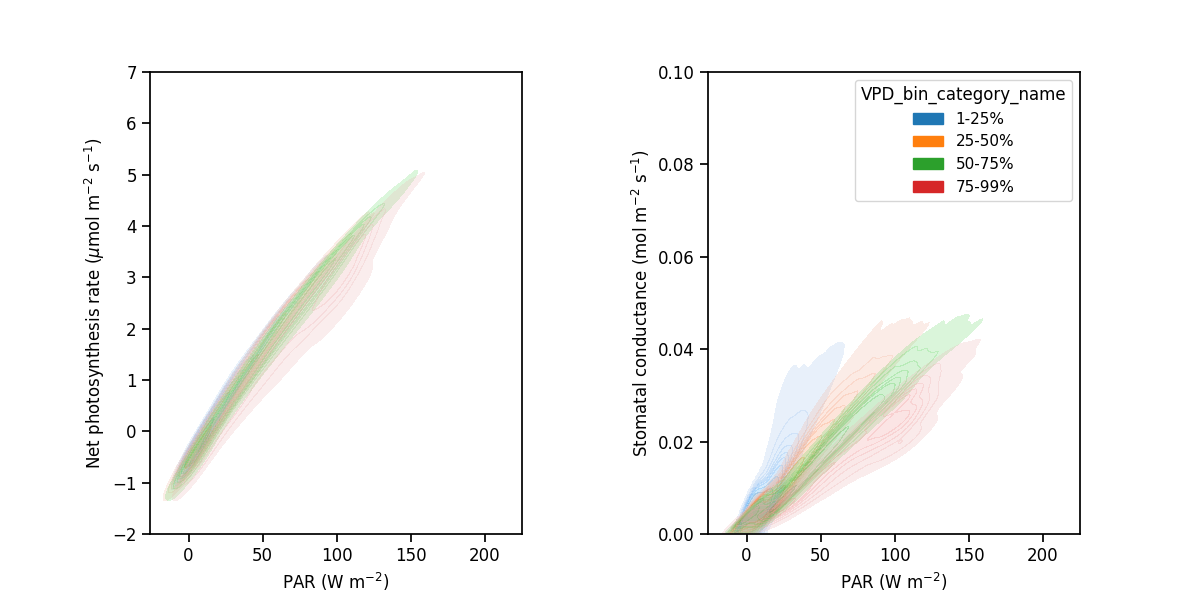

In [12]:
fig, axs = plt.subplots(figsize=(12,6), nrows=1, ncols=2)
axs = axs.flatten()
fig.subplots_adjust(wspace=0.5)
plot_data = data.loc[data.VPD_bins.isin([1,2,3,4])]

sns.kdeplot(plot_data, x='PAR',y='An', hue='VPD_bin_category_name', thresh=0.05, fill=True, ax=axs[0], alpha=0.25, legend=False)
sns.kdeplot(plot_data, x='PAR',y='gs', hue='VPD_bin_category_name', thresh=0.05, fill=True, ax=axs[1], alpha=0.25, legend=True)

for ax in axs:
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlabel('PAR (W m$^{-2}$)')

axs[0].set_ylabel('Net photosynthesis rate ($\mu$mol m$^{-2}$ s$^{-1}$)')
axs[1].set_ylabel('Stomatal conductance (mol m$^{-2}$ s$^{-1}$)')

axs[0].set_ylim([-2, 7])
axs[1].set_ylim([0, 0.1])


## Remove high g<sub>s</sub> values from plotting

In [13]:
plot_data_3d = data.loc[data.loc[:,'gs']<1, :]

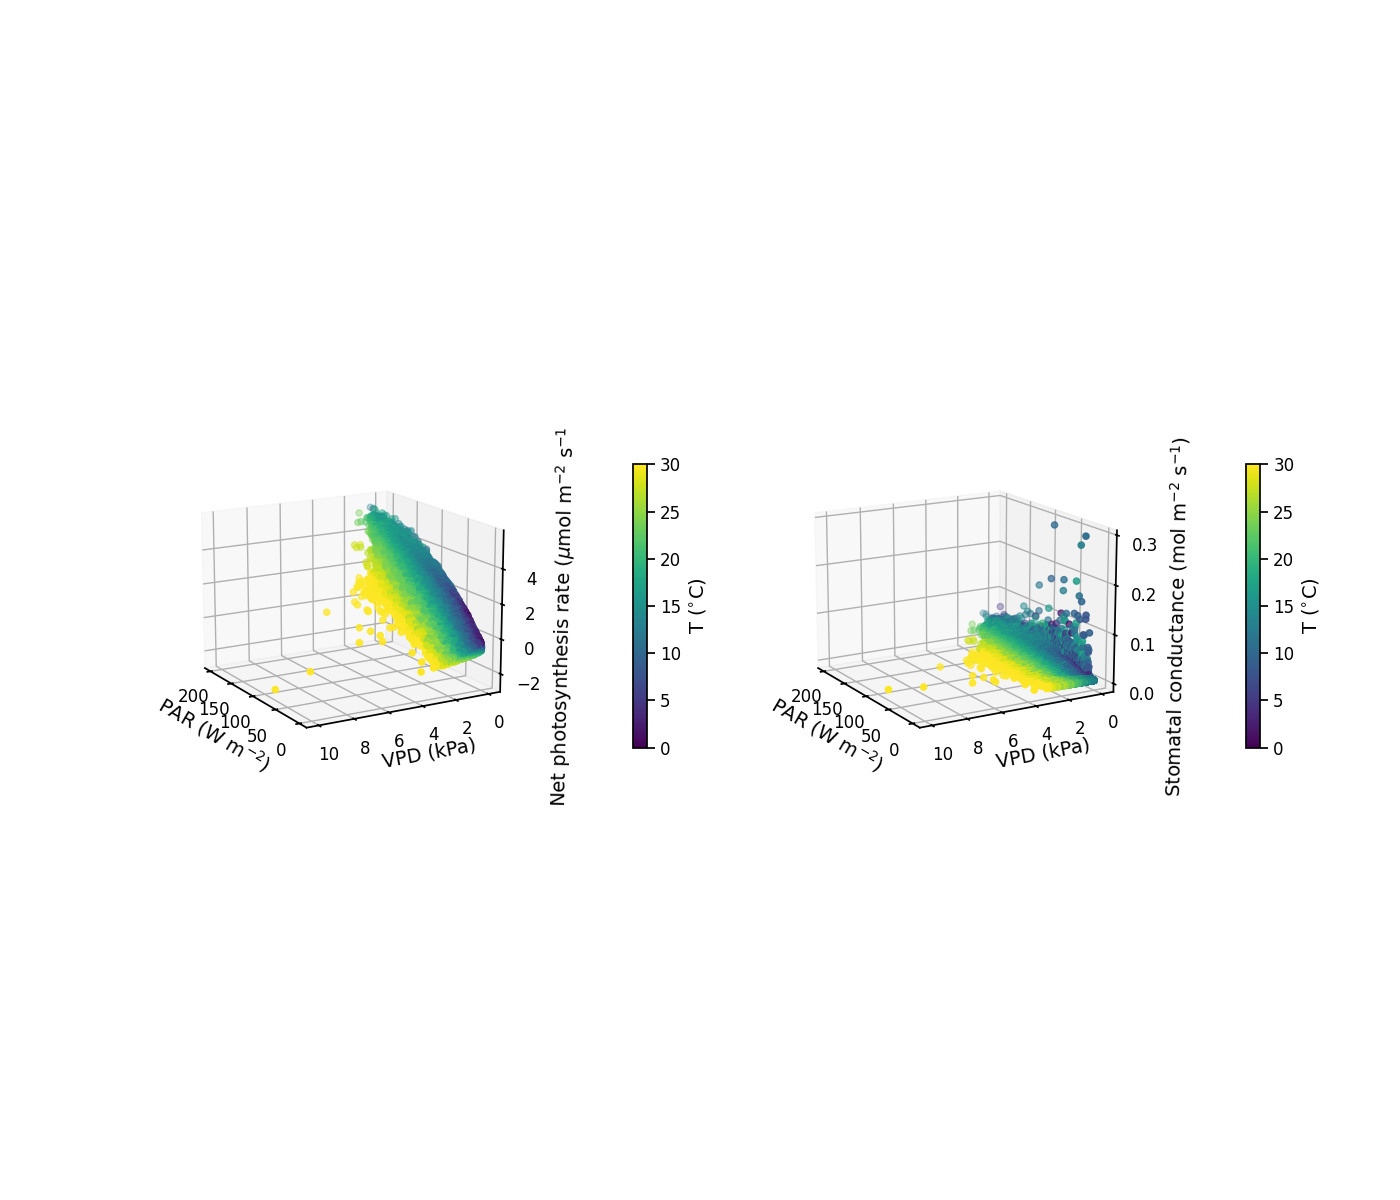

In [14]:
fig, axs = plt.subplots(figsize=(14,12), subplot_kw={'projection': '3d'}, ncols=2)
fig.subplots_adjust(wspace=0.3)
fs = 14
zlabels = ['Net photosynthesis rate ($\mu$mol m$^{-2}$ s$^{-1}$', 'Stomatal conductance (mol m$^{-2}$ s$^{-1}$)']
for i, (ax, z_val) in enumerate(zip(axs, [plot_data_3d.loc[:,'An'], plot_data_3d.loc[:,'gs']])):
    im = ax.scatter(plot_data_3d.loc[:,'PAR'], plot_data_3d.loc[:, 'VPD'], z_val, c=plot_data_3d.loc[:, 'T'],  vmin=0, vmax=30)
    ax.view_init(elev=15, azim=150, roll=0)

    cb = fig.colorbar(im, fraction=0.03, pad=0.25)
    cb.set_label('T ($^{\circ}$C)', fontsize=fs)
    cb.ax.tick_params(axis='y', labelsize=12)
    ax.set_ylabel('VPD (kPa)', fontsize=fs)
    ax.set_xlabel('PAR (W m$^{-2}$)', fontsize=fs)
    ax.set_zlabel(zlabels[i], fontsize=fs)

    ax.tick_params(axis='both', labelsize=12)

# Example 2: Solve A, g<sub>s</sub> and leaf temperature explicitly 

        r""" Initialises a planttype object and submodel objects
        using given parameters.

        Args:
            z (array): canopy model nodes, height from soil surface (= 0.0) [m]

            p (dict):
                'name' (str): name of planttype
                'LAImax' (float): maximum leaf area index [m2m-2]
                'lad' (array): normalized leaf area density profile [m2m-3]

                # following group needed only if ctr['pheno_cycle'] == True
                'phenop' (dict): parameters for seasonal cycle of phenology
                    'Xo': initial delayed temperature [degC]
                    'fmin': minimum photocapacity [-]
                    'Tbase': base temperature [degC]
                    'tau': time constant [days]
                    'smax': threshold for full acclimation [degC]

                # following group needed only if ctr['seasonal_LAI'] == True
                'laip' (dict): parameters for LAI seasonal dynamics
                    'lai_min': minimum LAI, fraction of annual maximum [-]
                    'lai_ini': initial LAI fraction, if None lai_ini = Lai_min * LAImax
                    'DDsum0': degreedays at initial time [days]
                    'Tbase': base temperature [degC]
                    'ddo': degreedays at bud burst [days]
                    'ddur': duration of recovery period [days]
                    'sso': start doy of decrease, based on daylength [days]
                    'sdur': duration of decreasing period [days]

                'photop' (dict): leaf gas-exchange and stomatal control parameters
                    'Vcmax': maximum carboxylation velocity [umol m-2 (leaf) s-1]
                    'Jmax': maximum rate of electron transport [umol m-2 (leaf) s-1]
                    'Rd': dark respiration rate [umol m-2 (leaf) s-1]
                    'alpha': quantum yield parameter [mol mol-1]
                    'theta': co-limitation parameter of Farquhar-model [-]
                    # 'm': stomatal parameter of Ball-Berry model
                    # 'La': stomatal parameter of stomatal optimality model
                    'g1': stomatal parameter of Medlyn A-gs model [kPa^0.5]
                    'g0': residual conductance for CO2 [molm-2s-1]
                    'kn': nitrgogen attenuation factor [-]; vertical scaling of Vcmax, Jmax, Rd
                    'beta':  co-limitation parameter of Farquhar-model [-]
                    'drp': drought-response parameters [UNITS]
                    'tresp' (dict): temperature sensitivity parameters
                        'Vcmax': [Ha, Hd, Topt]; activation energy [kJmol-1], deactivation energy [kJmol-1], optimum temperature [degC]
                        'Jmax': [Ha, Hd, Topt];
                        'Rd': [Ha]; activation energy [kJmol-1)]

                'leafp' (dict): leaf properties
                    'lt': leaf lengthscale [m]
                    'par_alb': leaf Par albedo [-]
                    'nir_alb': leaf Nir albedo [-]
                    'emi': leaf emissivity [-]

                'rootp' (dict): root zone properties
                    'root_depth': root depth [m]
                    'beta': shape parameter for root distribution model
                    'RAI_LAI_multiplier': multiplier for total fine root area index (RAI = 2*LAImax)
                    'fine_radius': fine root radius [m]
                    'radial_K': maximum bulk root membrane conductance in radial direction [s-1]

            dz_soil (array): thickness of soilprofile layers, needed for rootzone [m]

            ctr (dict): switches and specifications for computation
                'WaterStress' (str): account for water stress using 'Rew', 'PsiL' or 'None'
                'seasonal_LAI' (bool): account for seasonal LAI dynamics
                'pheno_cycle' (bool): account for phenological cycle
            loc (dict): site location
                'lat': latitude (decimal degrees)
                'lon': 'longitude (decimal degrees)
        Returns:
            self (object):
                .name (str)
                .pheno_state(float): phenology state [0...1]
                .relative_LAI (float): LAI relative to annual maximum [0...1]
                .lad (array): leaf area density [m2 m-3]
                .lad_normed (array): normalized leaf area density [-]
                ...
                .Switch_pheno (bool): account for phenological cycle
                .Switch_lai (bool): account for seasonal LAI dynamics
                .Switch_WaterStress (bool): account for water stress in planttypes
                .Pheno_Model (object): model for phenological cycle
                .LAI_Model (object): model for seasonal development of LAI
                .Roots (object): root properties
        """

## Import lad_weibull function for defining vertical leaf area density

In [15]:
from pyAPES.utils.utilities import lad_weibul

In [16]:
plant_name = 'Plant A'
LAImax = 2

## Calculate vertical LAD (m<sup>2</sup>(leaf)m<sup>-3</sup>(element))

In [17]:
z_canopy = np.linspace(0, 15, 15*4+1) # canopy grid with 0.25 element height
lad = lad_weibul(z_canopy, LAI=LAImax, h=10, hb=3, species='spruce') # Vertical leaf area density for 10 m birch with crown base heigth at 3m

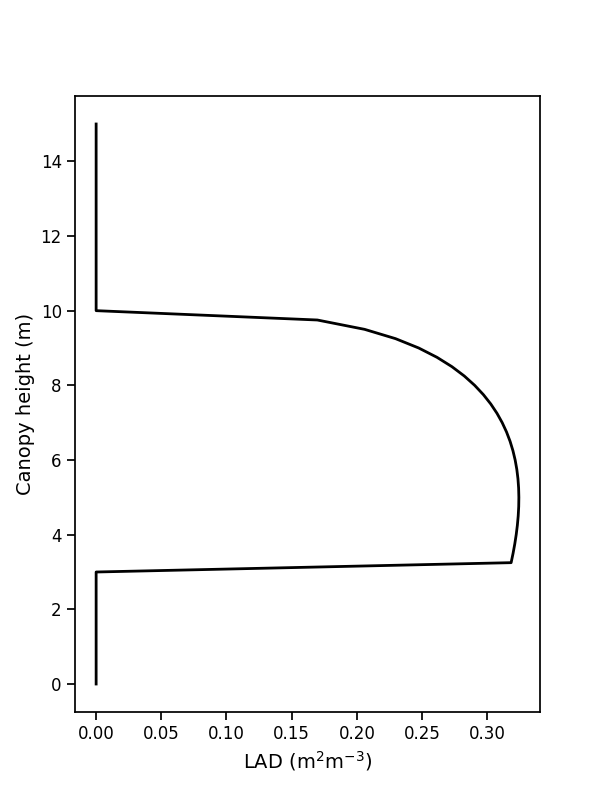

In [18]:
fig, ax = plt.subplots(figsize=(6,8))

ax.plot(lad, z_canopy,'k-', linewidth=2)
ax.set_xlabel('LAD (m$^2$m$^{-3}$)', fontsize=14)
ax.set_ylabel('Canopy height (m)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

In [50]:
lad_normed = lad/LAImax # PlantType object expects normalized lad i.e., sum(lad*dz)=1
# Set elements that have zero lad to nan to distinquish between elements that have leaves and those that have not
lad_normed[lad_normed == 0] = np.nan

## Define plant parameters

In [119]:
plant_params = {'name': plant_name, 'LAImax': LAImax, 'lad': lad_normed} # Plant parameters for PlantType object

dz_soil = np.diff(np.linspace(0, 1, 11)) # height of each soil element (=0.1m)


### Take photosynthesis and leaf parameters from Example1

In [120]:
plant_params['photop'] = plant['photop']
plant_params['photop']['photo_model'] = 'medlyn_farquhar_gm' #Define which photosynthesis model to use
plant_params['photop']['gm'] = {'gm25': 0.1, 'fmin': 0.15, 'tempstress': True, 'parstress': True, 'waterstress': True}
plant_params['leafp'] = plant['leafp']


### Define root parameters

These parameters need to be defined but are not used inside PlantType object themselves. These values are copied from mlm_parameters.py

In [121]:
plant_params['rootp'] = {
    'root_depth': 0.5,  # rooting depth [m]
    'beta': 0.943,  # root distribution shape parameter [-]
    'root_to_leaf_ratio': 2.0,  # fine-root to leaf-area ratio [-]
    'root_radius': 2.0e-3,  # [m]
    'root_conductance': 5.0e8,  # [s]
}

## Define control parameters

- WaterStress option defines are the photosynthesis parameters (plant["photop"] in Example 1) scaled based on relative extractable water (WaterStress: Rew) or leaf water potential (WaterStress: PsiL). The photoparameters are scaled in ```PlantType.run_daily()``` for which either Rew or PsiL needs to be given as input
- seasonal_LAI option defines whether to scale the lad based on seasonal cycle
- pheno_cycle option defines whether to scale the photosynthesis parameters (plant["photop"] in Example 1) based on the seasonal temperature cycle

here we turn all these options off which also means we don't need to define phenology or seasonal LAI related parameters.

In [122]:
control_params = {'WaterStress': None, 'seasonal_LAI': False, 'pheno_cycle': False, 'gm': True}

## Define location

Location is used to calculate inside PlantTybe object to calculate daylength if seasonal_LAI is True. Since we have turned off seasonal_LAI the location does not matter in this example

In [123]:
loc = [65.48, 25.11]

## Define PlantType object

In [124]:
from pyAPES.planttype.planttype import PlantType
ptype = PlantType(z_canopy, plant_params, dz_soil, control_params, loc)

## Define forcing values for calculating leaf gas exchange

We are going to be using the ```run``method of PlantType to solve A, g<sub>s</sub> and leaf temperature. We need to define following variables
```
   def run(self, forcing: Dict, parameters: Dict, controls: Dict) -> Tuple[Dict, Dict]:
        """
        Computes dry leaf gas-exchange for shaded and sunlit leaves for timestep.

        Args:
            forcing (dict):
                'h2o' (array): water vapor mixing ratio [mol mol-1]
                'co2' (array): carbon dioxide mixing ratio [ppm]
                'air_temperature' (array): air temperature [degC]
                'air_pressure' (float): ambient pressure [Pa]
                'wind_speed' (array): mean wind speed [m s-1]
                'par' (dict): incident and absorbed PAR [W m-2] for sunlit & shaded leaves seprately; see structure in caller
                'nir' (dict): --"-- for NIR
                'lw' (dict): long-wave related inputs, see structure from caller

            'parameters' (dict):
                'sunlit_fraction': array [-]
                'dry_leaf_fraction' (array) [-]

            'controls' (dict):
                'energy_balance' (boolean): True solves leaf temperature, False assumes Tleaf = air_temperature
```

## Define controls

We want to solve leaf temperature explicitly

In [125]:
control_params_run_planttype = {'energy_balance': True, 'logger_info': 'PlantA'}

## Define parameters

assume linear function from 1% to 75% of leaves are sunlit and all leaves are dry

In [126]:
sunlit_fraction = np.zeros_like(z_canopy)

# find indices which have leaves

ind_leaves = np.where(ptype.lad_normed>0)[0]

m = (0.75-0.01)/(z_canopy[ind_leaves[-1]] - z_canopy[ind_leaves[0]]) #slope of the sunlit fraction
b = 0.01

sunlit_fraction[ind_leaves] = (z_canopy[ind_leaves]-z_canopy[ind_leaves[0]])*m + b

Text(0, 0.5, 'Canopy height (m)')

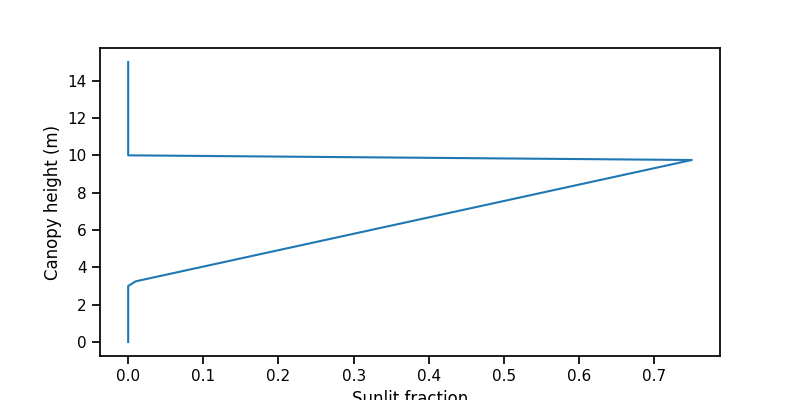

In [127]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(sunlit_fraction, z_canopy)
ax.set_xlabel('Sunlit fraction')
ax.set_ylabel('Canopy height (m)')

In [128]:
dry_leaf_fraction = np.zeros_like(z_canopy)+1

In [129]:
parameters_run_planttype = {'sunlit_fraction': sunlit_fraction, 'dry_leaf_fraction': dry_leaf_fraction}

## Define Forcing variables

In this example we'll study how the difference between air and leaf temperature changes when wind speed and incident PAR changes. We'll assume that 10% of the incident PAR is absorbed be the leaves

In [130]:
forcing = {}

incident_par = np.zeros_like(z_canopy)
incident_par[ind_leaves] = 50

absorbed_par = incident_par * 0.1
forcing['par'] = {'sunlit': {'incident': incident_par,
                             'absorbed': absorbed_par},
                  'shaded': {'incident': incident_par/2,
                             'absorbed': absorbed_par/2}}

forcing['nir'] = {'sunlit': {'absorbed': incident_par*4},
                  'shaded': {'absorbed': incident_par*4}
                  }

net_leaf_lw = np.zeros_like(z_canopy)
net_leaf_lw[ind_leaves] = 20
forcing['lw'] = {'net_leaf': net_leaf_lw,
                 'radiative_conductance': 2 * 4 * 0.3 * 5.6697e-8 * 0.5
                 * (283.15) ** 3 / 
                 (ptype.lad*0.25 + 1e-12) / 29.3}  # Radiative conductance of leaf (mol m-2(leaf) s-1), for demonstration purposes not accurate

In [131]:
forcing['h2o'] = np.zeros_like(z_canopy) + 0.0002 #mol/mol
forcing['co2'] = np.zeros_like(z_canopy) + 400 #ppm
forcing['air_temperature'] = np.zeros_like(z_canopy) + 25 # degC
forcing['air_pressure'] = np.zeros_like(z_canopy) + 101325 #Pa
forcing['wind_speed'] = np.zeros_like(z_canopy) + 1 #m/s 
forcing['average_leaf_temperature'] = np.zeros_like(z_canopy) + 22 # for initialization degC
forcing['wet_leaf_temperature'] = 20 #degC not needed since dry_leaf_fraction=1 but required by planttype.run()

In [132]:
ptype.Tl_sh = np.zeros_like(z_canopy) +forcing['air_temperature']
ptype.Tl_sh[ind_leaves] = 26
ptype.Tl_sl = np.zeros_like(z_canopy) + forcing['air_temperature']
ptype.Tl_sl[ind_leaves] = 26

## Solve leaf energy balance

planttype.run() returns two dictionaries in a tuple. First dictionary contains results for the whole plant level and the second contains results for each layer.

In [133]:
plant_results, layer_results = ptype.run(forcing, parameters_run_planttype, control_params_run_planttype)

Text(0.5, 0, 'A$_\\mathrm{net}$ ($\\mu$mol m$^{-2}$ s$^{-1}$)')

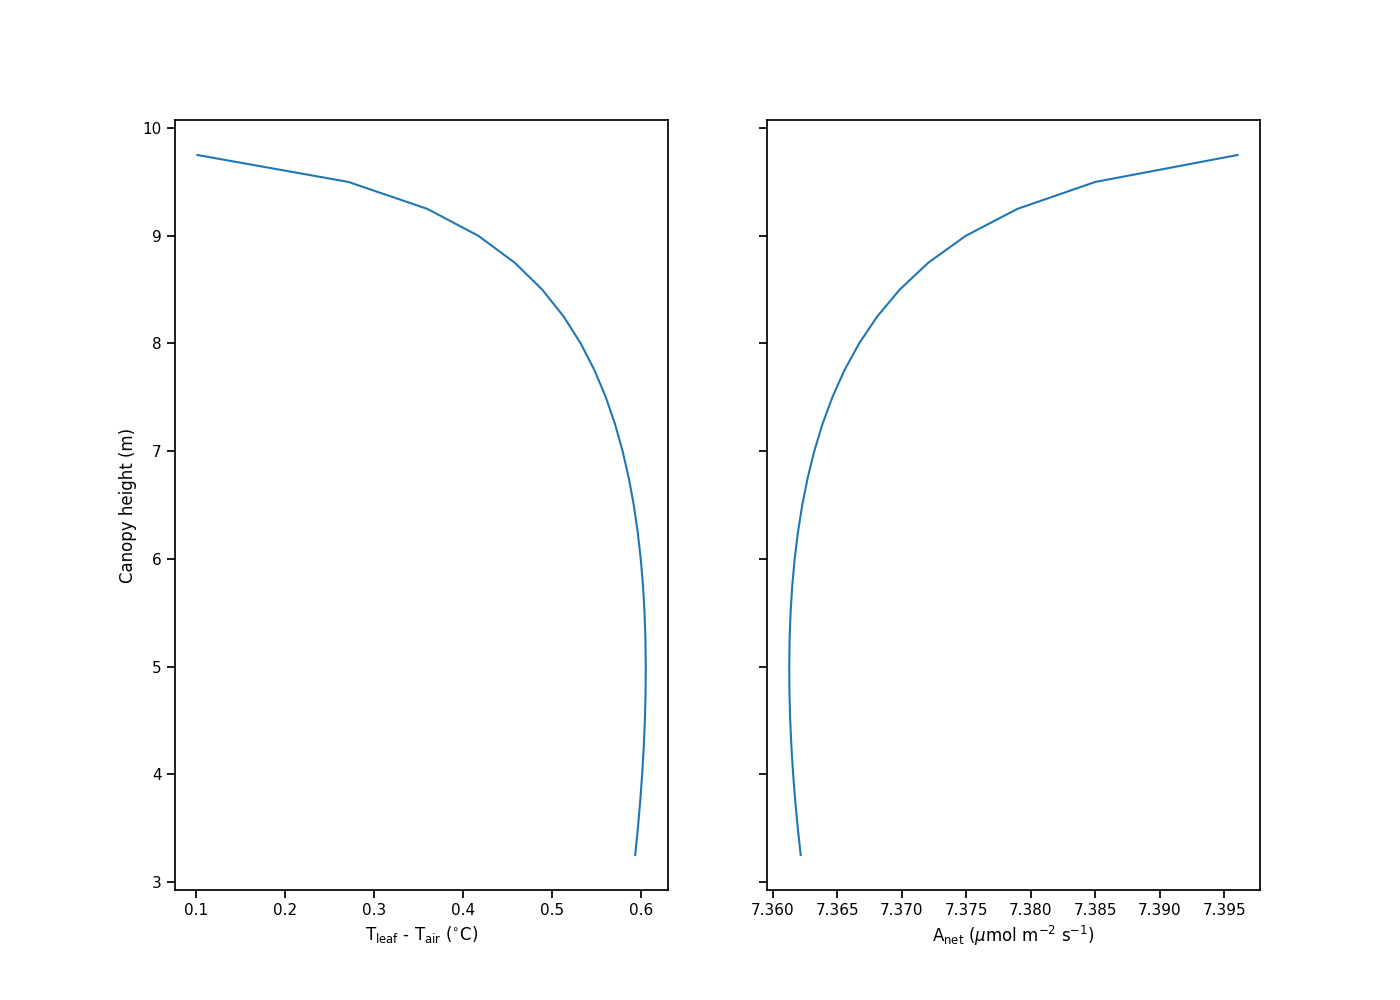

In [134]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(14,10))
axs = axs.flatten()
axs[0].plot(layer_results['leaf_temperature_sunlit']-forcing['air_temperature'], z_canopy)
axs[0].set_xlabel('T$_\mathrm{leaf}$ - T$_\mathrm{air}$ ($^{\circ}$C)')
axs[0].set_ylabel('Canopy height (m)')

axs[1].plot(layer_results['net_co2_sunlit'], z_canopy)
axs[1].set_xlabel('A$_\mathrm{net}$ ($\mu$mol m$^{-2}$ s$^{-1}$)')


## Run planttype with different incident PAR and wind speed values

We'll assume that the absorbed PAR is 10% of the incident PAR, shaded leaves receive 50% of the incident PAR and NIR intensity is 100% higher than the incident PAR.

In [135]:
inc_par_values = np.linspace(1,200,75)
wind_speed_values = np.linspace(0,5,11)

Tleaf = np.zeros((inc_par_values.shape[0], wind_speed_values.shape[0]))
ind_take_results = ind_leaves[0] + int(len(ind_leaves)/2) # middle point of the leaf layers
forcing = {}

for i, inc_par in enumerate(inc_par_values):
    for j, wind_speed in enumerate(wind_speed_values):
        incident_par[ind_leaves] = inc_par

        absorbed_par = incident_par * 0.1
        forcing['par'] = {'sunlit': {'incident': incident_par,
                                    'absorbed': absorbed_par},
                        'shaded': {'incident': incident_par/2,
                                    'absorbed': absorbed_par/2}}

        forcing['nir'] = {'sunlit': {'absorbed': incident_par*2},
                        'shaded': {'absorbed': incident_par*2}
                        }

        net_leaf_lw = np.zeros_like(z_canopy)
        net_leaf_lw[ind_leaves] = 20
        forcing['lw'] = {'net_leaf': net_leaf_lw,
                        'radiative_conductance': 2 * 4 * 0.3 * 5.6697e-8 * 0.5 * (283.15) ** 3 / (ptype.lad*0.25 + 1e-12) / 29.3}  # Radiative conductance of leaf (mol m-2(leaf) s-1), for demonstration purposes not accurate

        forcing['h2o'] = np.zeros_like(z_canopy) + 0.0002 #mol/mol
        forcing['co2'] = np.zeros_like(z_canopy) + 400 #ppm
        forcing['air_temperature'] = np.zeros_like(z_canopy) + 25 # degC
        forcing['air_pressure'] = np.zeros_like(z_canopy) + 101325 #Pa
        forcing['wind_speed'] = np.zeros_like(z_canopy) + wind_speed #m/s 
        forcing['average_leaf_temperature'] = np.zeros_like(z_canopy) + 22 # for initialization degC
        forcing['wet_leaf_temperature'] = 20 #degC not needed since dry_leaf_fraction=1 but required by planttype.run()
        plant_results, layer_results = ptype.run(forcing, parameters_run_planttype, control_params_run_planttype)
        Tleaf[i,j] = np.nanmean(layer_results['leaf_temperature_sunlit'])

In [136]:
from scipy.interpolate import RegularGridInterpolator

par_u_grid_orig = (inc_par_values, wind_speed_values)

par_grid = np.linspace(1,200, 100)
u_grid = np.linspace(0,5,100)

par_u_grid_fine = np.meshgrid(par_grid, u_grid)
par_u_grid_fine_flatten = np.transpose(np.array([i.flatten() for i in par_u_grid_fine]))

Tleaf_interpolator = RegularGridInterpolator(par_u_grid_orig, Tleaf, method='linear')
Tleaf_fine = Tleaf_interpolator(par_u_grid_fine_flatten)

# cast Tleaf_fine onto new 2d array
ind = 0
Tleaf_fine_2d = np.zeros((par_grid.shape[0], u_grid.shape[0]))
for i in range(par_grid.shape[0]):
    for j in range(u_grid.shape[0]):
        Tleaf_fine_2d[i,j] = Tleaf_fine[ind]
        ind = ind+1



Text(0.5, 0.92, 'T$_\\mathrm{air}$ = 25$^{\\circ}$C')

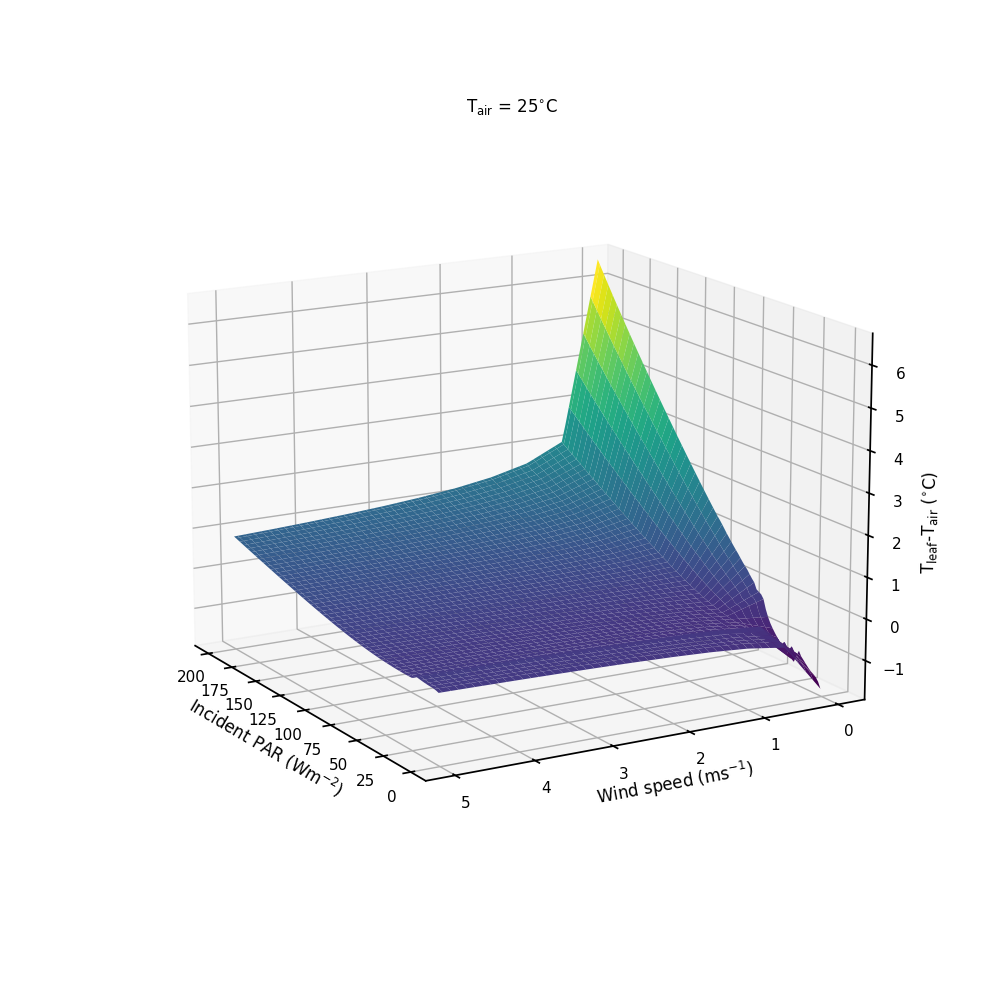

In [137]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(10,10))
ax.plot_surface(par_u_grid_fine[0], par_u_grid_fine[1], Tleaf_fine_2d-forcing['air_temperature'][0], cmap='viridis')
ax.view_init(elev=15, azim=150, roll=0)
ax.set_xlabel('Incident PAR (Wm$^{-2}$)')
ax.set_ylabel('Wind speed (ms$^{-1}$)')
ax.set_zlabel('T$_\mathrm{leaf}$-T$_\mathrm{air}$ ($^{\circ}$C)')
ax.set_title('T$_\mathrm{air}$ = 25$^{\circ}$C')